# genData: Generate mock data for HydroX
Created by Nathan Giha (giha@umich.edu) on 03 Feb. 2023 while working with the Noble Liquid group at SLAC/Stanford

Purpose: Generate mock GXe S1+S2 data for building processing scripts

## Contents of the script
### I. Define settings related to the output, digitizer, TPC, scintillation time profile, etc.
### II. Create a nestpy.NESTcalc for sampling quanta yields
### III. Import GXe $v_d$ and $D_L$ from A.C. McDonald et al. (NEXT 2019)
### IV. Define analytical functions for phd shape, CDFs, etc.

### V. Loop - generate N events and write to file
1.  Determine $E_d$
2.  Sample $N_\gamma$ and $N_e$ w/ NEST
3.  Uniformly sample interaction depth
4.  Calculate diffusion width w/ AC McDonald
5.  Generate S2 pulse
    - (convolution of scintillation double exp, top-hat, and gaussian smearing from diffusion+other)
    - Gain calculated w/ $N_e$ from NEST and g2 from LZ
6.  Split S2 pulse among channels using Dirichlet distribution
7.  Determine time offset of S1 relative to S2 (drift time, AC McDonald)
8.  Sample phd time from convolution of scintillation double exp and gaussian
9.  Apply double photoelectron emission probability
    - For S1 pulses: chance to place two phd's in the same channel is P_DPE
    - For S2 pulses: scale by 1+P_DEP (assume N>>1)
10. Add PMT dark counts based on user-defined dark rate
    - Sample poisson dist. with mean of dark rate * acquisition window for each channel
    - Uniformly distribute sampled # of PMT pulses in window
11. Multiply wfs by digitizer gain (phd density -> digitizer units)
12. Add baseline
13. Add RMS noise
14. Write to file

## I. Settings
The user gives information about the output, physical conditions, digitizer, etc. here

In [1]:
# Set constants

# For this notebook's outputs
OUTPUT_NAME     = "pyOutput_N=1.dat"
N_EVENTS        = 1e1   # WARNING: It's very slow and generates a lot of data.
                      #          Mess with it a bit before exceeding N=100.

# Inside the TPC
PRESSURE        = 3      # bar
FIELD_STRENGTH  = 260    # V/cm
TEMP            = 190.   # K
TEMP_0          = 293.15 # K ; Reference temperature from AC McDonald (2019)
DEPTH           = 4.     # cm
G_1             = 0.114  # S1 phd/quantum, lifted directly from LZ SR1 arXiv:2207.03764v3
G_2             = 47.1   # S2 phd/quantum


# Digitizer settings
DGTZ_GAIN       = 50     # Tune to get correct phd / dig. unit
DGTZ_BASELINE   = 8192   # Baseline in digitizer units
N_CHANNELS      = 32
RECORD_LENGTH   = 4096   # Number of samples in a wf
DIG_PERIOD      = 8      # ns ; 1/digitizer rate
S2_START_FR     = 0.75    # Position of S2 rising edge in record (0 < S2_START_FR < 1)


# Pulse shaping constants
## Scintillation
FAST_FR         = 0.5    # Fraction of scintillation light that is fast
T_F             = 10     # ns
T_S             = 100    # ns
## Extraction
EXTR_T          = 1500   # ns ; non-diffused S2 width = d_extr / v_drift,extr = 3 mm / (2mm/us) = 1500 ns) ; numbers from Sparshita's COMSOL sims
## Electronics
SIGMA_E         = 20     # ns ; Gaussian time smearing from amplification, etc.

## PMT stuff
PHD_WIDTH       = 10     # ns ; (gaussian) width of a photoelectron signal
DARK_RATE       = 0.0001   # ms^-1 ; dark count rate for a PMT (CHECK VALUE)
P_DPE           = 0.22   # (arXiv:1801.01597) probability of double photoelectron emission (~22.6% for Hamamatsu R11410-22, LZ PMTs)
SIGMA_RMS       = 0.01   # digitizer units ; baseline RMS noise
SIMPLE_S2       = False   # Use simplified S2 model


S2_WINDOW       = 3000   # ns ; S2 finite signal range to prevent floating point math errors

In [2]:
%%time

# Load packages

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
# from scipy.optimize import curve_fit
from time import time

from scipy.special import erf
from scipy.special import erfc

from scipy.interpolate import interp1d

import nestpy

from numba import jit, njit


# from scipy.stats import exponnorm


tickSize = 15
params = {'legend.fontsize': 'medium',
          'font.family': 'serif',
          'figure.figsize': (6,4),
          'axes.labelsize': tickSize,
          'axes.titlesize': tickSize,
          'xtick.labelsize': tickSize,
          'ytick.labelsize': tickSize}
plt.rcParams.update(params)

CPU times: user 1.08 s, sys: 2.16 s, total: 3.24 s
Wall time: 2.57 s


## II. NEST

In [3]:
# detector = nestpy.DetectorExample_XENON10()
detector = nestpy.VDetector() # Note: detector choice does not affect the generated quanta. Could be important
                              # if we were to use NEST drift fields, pulse shapes, etc. in the future.
detector.set_inGas(True)
nc = nestpy.NESTcalc(detector)
rho = nc.SetDensity(TEMP, PRESSURE)
print("Density is %s g/cm^3" % rho)

# detector.set_inGas(True)

interaction = nestpy.INTERACTION_TYPE(0)  # NR

Density is 0.0259425025946047 g/cm^3


## III. Import
The drift velocity $v_{drift}$, pressure-weighted diffusion coefficient $D_L P$, and reduced longitudinal diffusion coefficient $D_L^*$ are given as a function of the reduced electric field strength $\varepsilon / P$ [V/cm/bar] in A.C. McDonald et al.

These parameters are used to determine the time between S1 and S2 pulses, and the time diffusion in ionization electrons making it to the grid.

The data were digitized and are imported here, then interpolated with a spline.

#### Note for H$_2$ doping
Assuming these parameters are affected in a similar way as in He doping, we can expect $v_{drift}$ and $D_L$ to increase with %H$_2$. Couldn't find literature to quantify for H$_2$.

In [4]:
%%time
# Load data
vDriftFile = np.genfromtxt("data/vDrift.csv", delimiter = ",", skip_header = 0) # read digitized vDrift data
getVDrift = interp1d(vDriftFile[:,0],vDriftFile[:,1], kind="slinear")

DLstarFile = np.genfromtxt("data/DL*.csv", delimiter = ",", skip_header = 0)
getDLstar = interp1d(DLstarFile[:,0],DLstarFile[:,1], kind="slinear")

DLPFile = np.genfromtxt("data/DLP.csv", delimiter = ",", skip_header = 0)
getDLP = interp1d(DLPFile[:,0],DLPFile[:,1], kind="slinear")


vDrift = getVDrift(FIELD_STRENGTH / PRESSURE) # units mm/us
# DLstar = getDLstar(FIELD_STRENGTH / PRESSURE) # units sqrt(bar) um / sqrt(cm)
DLP = getDLP(FIELD_STRENGTH / PRESSURE)    # bar cm^2 / s
print(getDLP(260))
print(DLP)

239.07759490686385
342.37790444323394
CPU times: user 4.53 ms, sys: 5.21 ms, total: 9.74 ms
Wall time: 10.8 ms


## IV. Define functions

PDFs and such were determined analytically. 
### distScint
For the S1 signal, photon detection times are drawn from a double-exponental distribution convoluted with a Gaussian. The functional form is

$PDF_{s1}(t) = \frac{1}{2} \frac{1}{F \tau_f + (1-F)\tau_s} \left(F \mathrm{exp}\left(-\frac{t}{\tau_f}+\frac{\sigma^2}{2\tau_f^2}\right) \mathrm{erfc}\left(\frac{\sigma^2/\tau_f - t}{\sqrt{2} \sigma}\right)  + (1-F) \mathrm{exp}\left(-\frac{t}{\tau_s}+\frac{\sigma^2}{2\tau_s^2}\right) \mathrm{erfc}\left(\frac{\sigma^2/\tau_s - t}{\sqrt{2} \sigma}\right)\right)$

where $F$ is the fraction of prompt scintillation light, $\tau_{f,s}$ are the scintillation lifetimes, and $\sigma$ is the spread due to electronics, etc. This function is not actually used.

### cdfScint
This is the cdf for photon detection sampling.

$ CDF(t) = \frac{1}{2} \frac{1}{F \tau_f + (1-F)\tau_s} \left( (F \tau_f + (1-F) \tau_s) \mathrm{erf}\left(\frac{t}{\sqrt{2}\sigma}\right) - F \tau_f \mathrm{exp}\left(-\frac{t}{\tau_f} + \frac{\sigma^2}{2\tau_f^2}\right)\mathrm{erfc}\left(\frac{\sigma^2/\tau_f - t}{\sqrt{2} \sigma}\right) + \mathrm{exp}\left(-\frac{t}{\tau_s} \right) \left((F\tau_f + (1-F)\tau_s)\mathrm{exp}\left(\frac{t}{\tau_s}\right)-(1-F)\tau_s\mathrm{exp}\left(\frac{\sigma^2}{2\tau_s}\right)\mathrm{erfc}\left(\frac{\sigma^2/\tau_s - t}{\sqrt{2} \sigma}\right) \right) \right)$

### getS2
The s2 signal is scintillation response convoluted with another Gaussian for diffusion during drift and a top hat for (uniform electroluminescent production during) extraction. The above distScint, convoluted with a top hat of width $T$, $hat(t)=\frac{1}{T}\left(Heaviside(t) - Heaviside(t-T)\right)$, is simply the difference of the CDFs, $\frac{1}{T}\left(\mathrm{CDF}(t) - \mathrm{CDF}(t-T)\right)$. The diffusion $\sigma_D$ can be added in quadrature with any other $\sigma$.

$s2(t) = \frac{1}{T} \left(\int_{-\infty}^t PDF(x)dx - \int_{-\infty}^{t-T} PDF(x)dx \right)$


### gaussianPhd
This is simply the shape of a single PMT pulse. It's a Gaussian. $\sigma = 10$ ns if you believe the NEST LZ header.

In [6]:
%%time

# Double-exp convoluted with Gaussian (pdf)
def distScint(t,faFr, tF, tS, sigma):
    return 1/2 * 1/(faFr*tF + (1-faFr)*tS) * (\
            faFr*np.exp(-t/tF+sigma**2/(2*tF**2))*erfc((sigma**2/tF - t)/(np.sqrt(2)*sigma)) + \
            (1-faFr)*np.exp(-t/tS+sigma**2/(2*tS**2))*erfc((sigma**2/tS - t)/(np.sqrt(2)*sigma))  )

# The above pdf, integrated between -Inf and t
def cdfScint(t,faFr, tF, tS, sigma):
    
    # Issues with float64 overflow when sigma >> tF, band-aid this with guards
    # Will still generate exp overflow warnings, but seems to be functionally ok
    
    if np.isfinite(np.exp(sigma**2/(2*tF**2))):
        tF_exp = np.exp(sigma**2/(2*tF**2))
    else:
        tF_exp = 1e20 # Arbitrary large number that doesn't cause multiplication overflow errors

    if np.isfinite(np.exp(sigma**2/(2*tS**2))):
        tS_exp = np.exp(sigma**2/(2*tS**2))
    else:
        tS_exp = 1e20

#     print("___")
#     print(tF_exp)
#     print(tS_exp)
    
    cdf = 1/2 * 1/(faFr*tF + (1-faFr)*tS) * np.exp(-t*(1./tF+1./tS)) * \
           (np.exp(t*(1./tF+1./tS)) * (faFr*tF + (1-faFr)*tS)*erf(t/(np.sqrt(2)*sigma))   \
            - faFr * tF * np.exp(t/tS) * tF_exp * erfc((sigma**2/tF - t)/(np.sqrt(2)*sigma))
            + np.exp(t/tF) * ((faFr*tF + (1-faFr)*tS) * np.exp(t/tS) - (1-faFr)*tS * tS_exp * \
                             erfc((sigma**2/tS - t)/(np.sqrt(2)*sigma)) )
           )
    if (cdf.size > 1):
        cdf[np.argwhere(~np.isfinite(cdf))] = 0
        
    return cdf

# Convolution of double-exp, Gaussian, and top-hat of width T
# def getS2(t,faFr, tF, tS, sigma, T, simple = True, N = 1):
#     if simple:
#         return getS2_simple(t,faFr, tF, tS, sigma, T)
#     else:
#         return getS2_detailed(t,faFr, tF, tS, sigma, T, N)

def getS2_simple(t,faFr, tF, tS, sigma, T):
    return 1/T * (cdfScint(t,faFr,tF,tS,sigma) - cdfScint(t-T,faFr,tF,tS,sigma))

def getS2_detailed(t,faFr, tF, tS, sigma_el, T, N_el, sigma_depth):
    # Initialize output
    [output, phdS2] = [np.zeros((N_CHANNELS, t.size)), 0]
    
    # Sample depths
    eDepths = np.random.normal(0, sigma_depth, N_el) # sigma_depth in cm
    eTimes  = eDepths / vDrift * 1e4 # cm/(mm/us) to ns ; 
    eGains  = G_2 * np.ones(N_el)
    
    # Numerically construct cdf
    tSamp = np.arange(-S2_WINDOW, S2_WINDOW, 0.1)
    s2 = getS2_simple(tSamp, faFr, tF, tS, sigma_el, T)
    s2[s2<0] = 0                                         # Trim the rare negative value, e.g. -1e-12 -> 0
    s2 /= np.sum(s2)                                     # Renormalize
    
    # Calculate # of photons detected
    N_ph = np.round(eGains[0]).astype(int)

    # Determine photon channel partition
    dirichletAlpha = 0.1 # degree of similarity (>1 for similar, <1 for bias toward one channel)
    channels = np.random.choice(np.arange(0, N_CHANNELS), (N_el, N_ph),
                                p = np.random.dirichlet(dirichletAlpha * np.ones(N_CHANNELS), 1)[0])
    
    # Generate photon times and DPE occurrences
    phTimes = np.random.choice(tSamp, size=(N_el, N_ph), p=s2)
    doDPE = np.random.rand(N_el, N_ph) < P_DPE

    phdS2 += N_el * N_ph + np.sum(doDPE) # Increment total phd



    # For each electron
    for el in range(N_el):
        
        # Add photon wfs to output
        for ph in range(N_ph):
            phTime = eTimes[el] + phTimes[el][ph]
#             print(eTimes[el] + phTimes[ph])

            # Check for double photoelectron emission  
            if doDPE[el][ph]:
                output[channels[el][ph]] += 2*gaussianPhd(t, phTime, PHD_WIDTH) # Add same wf to same spot
            else:
                output[channels[el][ph]] += gaussianPhd(t, phTime, PHD_WIDTH)


                    

    return [output, phdS2]
            
        
# Failed attempt to use built-in functions, unused
# Reason for failure: independently sampling the exponentials leads to a different behavior than cdf.
# But maybe it's the right one?
# def sampleScint(faFr, tF, tS, sigma, N):
#     ret = np.zeros(N)
#     for n in range(N):
#         ret[n]= faFr*(np.random.exponential(tF) + np.random.normal(0, sigma)) + (1-faFr)*(np.random.exponential(tS) + np.random.normal(0, sigma))
#     return ret

# Single phd in PMT
def gaussianPhd(time, mu, sigma):
    return np.array(np.exp(-(time-mu)**2/(2*sigma**2)) / np.sqrt(2*np.pi*sigma**2))

# Apply Gaussian voltage noise
def applyRMS(signal, sigma):
    return np.random.normal(0,sigma,np.shape(signal))

# Apply zero suppression to reduce 
def zeroSuppress(wf, threshold):
    condition = np.less(np.absolute(wf), threshold)
    return np.where(condition, 0, wf)

# # GXe vdrift analytical fit from Sparshita's slides
# def vDriftAnanytical(E, a=4.18*(10**22), b=1.44*(10**115), g=4.06*(10**106), d=4.18*(10**21), e=6.82*(10**17), N=8.6266e+19):
#     return (a*E/N + b*(E/N)**6.)/(1 + g*(E/N)**5.8) + d*E/N*np.exp(-e*N/E)


# cdfScint(6405,0.5,10,100,400)

# t = np.linspace(-4952,6409,1000)
# t = np.linspace(-12000,12000,1000)

# s2 = getS2(time,0.5, 10, 100, 20, 1500)
# s2[s2<0] = 0
# s2 /= np.sum(s2)
# print('Integral is %s' % np.trapz(s2, time))


# def getS2_simple(t,faFr, tF, tS, sigma, T):
# hist = np.random.choice(time, size=1000000, p=s2)
# plt.hist(hist, bins = 100, density=True)

# s2 = getS2_detailed(t,0.5, 10, 100, 20, 1500, 1, 0.5)
# plt.plot(t, np.sum(s2[0], axis = 0))
# print('Integral is %s, N is %s' % (np.trapz(np.sum(s2[0], axis = 0), t), s2[1]))
# print(s2[1])
# for i in range(N_CHANNELS):
#     plt.plot(t, s2[0][i])
# plt.plot(t, s2[1]*getS2_simple(t, 0.5, 10, 100, 20, 1500))
# plt.plot(t[1:], np.diff(getS2_simple(t, 0.5, 10, 100, 20, 1500)))

CPU times: user 10 µs, sys: 1 µs, total: 11 µs
Wall time: 12.9 µs


## V. Loop

NEST time: 2.6226043701171875e-05
MC time: 2.8397438526153564
Write time: 7.152557373046875e-07
CPU times: user 29.9 s, sys: 78.2 ms, total: 30 s
Wall time: 30 s


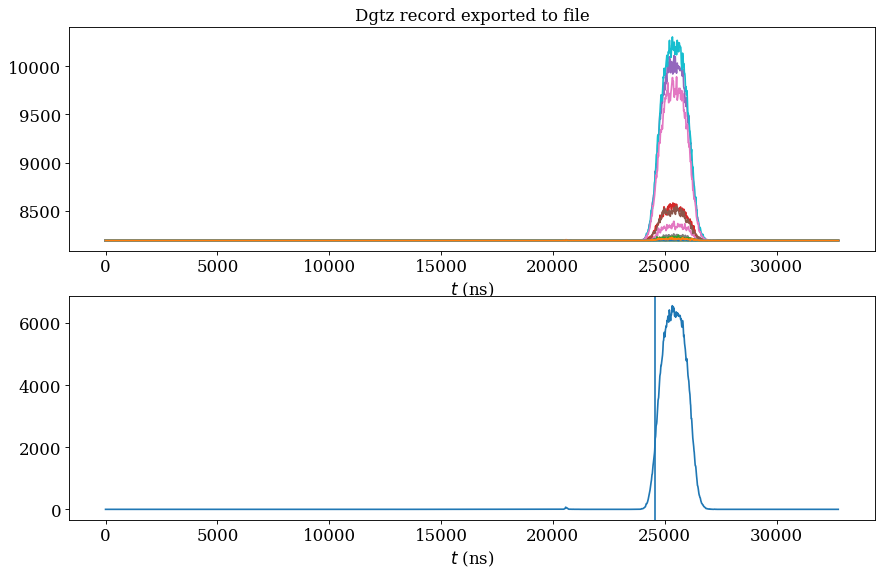

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

In [9]:
%%time


# Main loop: generate signals and write to file

outputTime = np.linspace(0, DIG_PERIOD*(RECORD_LENGTH-1), RECORD_LENGTH, dtype=int) # Time axis
outputMat = np.zeros((N_CHANNELS, RECORD_LENGTH)) # Empty event

detections = np.zeros((int(N_EVENTS), 2)) # Counting statistics

DLP = getDLP(FIELD_STRENGTH/PRESSURE)
vDrift = getVDrift(FIELD_STRENGTH/PRESSURE)


tSamp = np.arange(-500,1500,0.1) # Prepare for interpolating cdf -> sampling S1 phd times
s1_cdf = cdfScint(tSamp,FAST_FR,T_F,T_S,SIGMA_E)


startInd = round(S2_START_FR * RECORD_LENGTH)         # Determine where to place S2 in record
if SIMPLE_S2: # If using simple model, generate shape beforehand
    s2Time = np.arange(-S2_WINDOW, S2_WINDOW, DIG_PERIOD) # Make sub-window since analytic S2 shape likes to throw errors at large times
    s2shape = getS2_simple(s2Time, FAST_FR, T_F, T_S, sigmaS2, EXTR_T)

else:
    s2Time = np.arange(-DIG_PERIOD*(RECORD_LENGTH)/2, DIG_PERIOD*(RECORD_LENGTH-1)/2, DIG_PERIOD)
    zeroIndex = np.argmax(s2Time==0)
    
# Recreate output file
with open(OUTPUT_NAME,'w') as fout:
    fout.close()


for i in range(int(N_EVENTS)):
    outputMat.fill(0)
    
    energy = 100 # keV
#     energy = np.random.uniform(1., 40.) # keV

    
    startNEST = time()

    # Uniformly sample NR and beta
#     possibleInteractions = [0,8] # NR = 0, beta = 8
#     interaction = nestpy.INTERACTION_TYPE(possibleInteractions[np.random.randint(0,2)])  # NR or beta

#     interaction = nestpy.INTERACTION_TYPE(0)  # NR only
    interaction = nestpy.INTERACTION_TYPE(8)  # beta only




    y = nc.GetYields(interaction, energy, rho, FIELD_STRENGTH) # Not sure if this knows it's a gas, density might be all that matters
    
    # Mean quanta produced
    nPh = y.PhotonYield
    nEl = y.ElectronYield
    
    # With statistical fluctuations
    nPh = nc.GetQuanta(y).photons
    nEl = nc.GetQuanta(y).electrons
    


    
    stopNEST = time()

    startMC = time()

    # Generate z
    z = DEPTH * np.random.rand() # cm ; generate uniformly in TPC
#     z = 0.1
    
    # Calculate st devs from diffusion coefficient
    sigma_cloudSize = 0.000005 #cm
    sigmaD_z = np.sqrt(2*1e-5 * DLP * z / (PRESSURE * vDrift) * TEMP/TEMP_0) # units of cm
    sigmaD_t =  sigmaD_z / vDrift * 1e4 # units of ns
#     print("sigmaD_z %s" % sigmaD_z)


#     sigmaD = np.sqrt(1e3*2*DLP * z / (PRESSURE * vDrift**3) * TEMP/TEMP_0) # units of ns
#     print("error is %s" % (sigmaD_t - sigmaD))




    # Generate S2 signal
    
    if SIMPLE_S2:
        phdS2 = G_2 * nEl * (1 + P_DPE)
        sigmaS2 = np.sqrt(SIGMA_E**2 + sigmaD_t**2)

        s2 = phdS2 * s2shape


        # Pseudorandomly spread S2 signal across output channels
        dirichletAlpha = 3 # degree of similarity (>1 for similar, <1 for bias toward one channel)
        randDirichlet=np.random.dirichlet(dirichletAlpha * np.ones(N_CHANNELS), 1) 
        prod = np.transpose(np.matmul(np.transpose([s2]),randDirichlet))

        # Place S2 signals in output chans s.t. zero of S2 signal is coincident with pre-defined point in aq window 
        outputMat[:, int(startInd-S2_WINDOW/DIG_PERIOD):int(startInd+S2_WINDOW/DIG_PERIOD)] = prod
        
    else:
        [s2, phdS2] = getS2_detailed(s2Time, FAST_FR, T_F, T_S, SIGMA_E, EXTR_T, nEl, np.sqrt(sigmaD_z**2 + sigma_cloudSize**2))

        samp1 = np.argmax(np.sum(np.abs(s2), axis=0) > 0)
        samp2 = np.max(np.nonzero(s2))

        outputMat[:,(startInd-zeroIndex+samp1):(startInd-zeroIndex+samp2)] = s2[:,samp1:samp2]


        
        

    
    # Determine number of S1 photons
    phdS1 = round(G_1 * nPh)

    s1_offset = z / vDrift / 1e-4 # ns

    for ph in range(phdS1):
        # Generate timestamp for the phd ; linearly interpolate CDF sampling
        
        x = np.random.rand()
        samp = np.argmax(s1_cdf > x)
        s1t = tSamp[samp-1] + (tSamp[samp]-tSamp[samp-1])/(s1_cdf[samp]-s1_cdf[samp-1]) * (x - s1_cdf[samp-1]) \
              + (outputTime[startInd] - s1_offset)
        
        # Add phd signal to a random channel
        ch = np.random.randint(0,N_CHANNELS)
        outputMat[ch] += gaussianPhd(outputTime, s1t, PHD_WIDTH)

        # Sample double photoelectron emission
        doDPE = np.random.rand()
        if doDPE < P_DPE:
            outputMat[ch] += gaussianPhd(outputTime, s1t, PHD_WIDTH) # Add same wf to same spot
            phdS1+=1

    # Add dark counts
    for ch in range(N_CHANNELS):
        phdDark = np.random.poisson(lam = N_CHANNELS * (DARK_RATE/1e6) * RECORD_LENGTH * DIG_PERIOD)
        for ph in range(phdDark):
            phdDarkTime = np.random.rand() * RECORD_LENGTH * DIG_PERIOD
            outputMat[ch] += gaussianPhd(outputTime, phdDarkTime, PHD_WIDTH)
    
    
    outputMat *= DGTZ_GAIN                       # Convert phd to digitizer units
    outputMat += applyRMS(outputMat, SIGMA_RMS)  # Apply noise
#     outputMat = zeroSuppress(outputMat,1.1)      # Suppress noise
    outputMat += DGTZ_BASELINE                   # Add nonzero baseline


    stopMC = time()
    
    
    # Write synthesized event to file
    startWrite = time()

    doWrite = False
    if doWrite:
        with open(OUTPUT_NAME,'a+') as fout:

            # Write header, including timestamp
            header = np.empty(16, dtype='object')
            header[0]  = ('caaacaaa'+'\n')         # CAAACAAA
            header[1]  = (format(i,'x')+'\n')      # PACKET COUNTER
            header[2]  = (format(i,'x')+'\n')      # SUM_OUT
            header[3]  = (format(i,'x')+'\n')      # TRIG_COUNTS
            header[4]  = (format(2*i,'x')+'\n')    # TIME_COARSE
            header[5]  = (format(i,'x')+'\n')      # TIME_FINE
            header[6]  = (format(0,'x')+'\n')      # empty
            header[7]  = (format(0,'x')+'\n')      # empty
            header[8]  = (format(0,'x')+'\n')      # empty
            header[9]  = (format(0,'x')+'\n')      # empty
            header[10] = (format(0,'x')+'\n')      # empty
            header[11] = (format(0,'x')+'\n')      # empty
            header[12] = (format(0,'x')+'\n')      # empty
            header[13] = (format(0,'x')+'\n')      # empty
            header[14] = (format(0,'x')+'\n')      # empty
            header[15] = (format(0,'x')+'\n')      # empty

            fout.writelines(header)

            # Write waveforms
            for s in range(RECORD_LENGTH):
                for ch in range(int(N_CHANNELS / 2)):
                    smash = (outputMat[ch][s].astype(np.uint16) << 16) + outputMat[ch+1][s].astype(np.uint16)
                    fout.write(format(smash,'x')+'\n')
    
    stopWrite = time() 
    
    detections[i] = [phdS1, phdS2] # Record S1 and S2 phd
    
    if i%10==0:
        print('%s / %s' % (i, int(N_EVENTS)), end='\r')

    
#     print('The photon yield is:', y.PhotonYield)
#     print('The electron yield is:', y.ElectronYield)
#     print('With statistical fluctuations', nc.GetQuanta(y).photons, " ", nc.GetQuanta(y).electrons)
#     print("S2 photons detected: %s" % (phdS2))
#     print("S1 photons detected: %s" % (phdS1))




timeNEST = stopNEST - startNEST
timeMC   = stopMC - startMC
timeWrite = stopWrite - startWrite
print("NEST time: %s" % (timeNEST))
print("MC time: %s" % (timeMC))
print("Write time: %s" % (timeWrite))

doPlot = True
if doPlot:
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(13, 8), dpi=80)
    
    plt.figure()
    for i in range(N_CHANNELS):
        ax1.plot(outputTime,outputMat[i], label = ("ch" + str(i)))

    plt.figure()
    ax2.plot(outputTime, np.sum(outputMat,axis=0) - N_CHANNELS * DGTZ_BASELINE)
    ax2.axvline(outputTime[startInd])

#     ax2.legend()
    ax1.set_title("Dgtz record exported to file")
    ax1.set_xlabel("$t$ (ns)")
    ax2.set_xlabel("$t$ (ns)")

#     plt.ylabel("d.u.")


# Validating NEST

The below log$_{10}$S2-S1 plots show the data that are imported from NEST and only slightly modified: multiplied by appropriate g1/g2 (in this case, LZ) and modified for double photoelectron emission. Unlike the other validation sections, you'll have to run the above loop to generate these plots.

Text(0, 0.5, 'log$_{10}$(S2 [phd])')

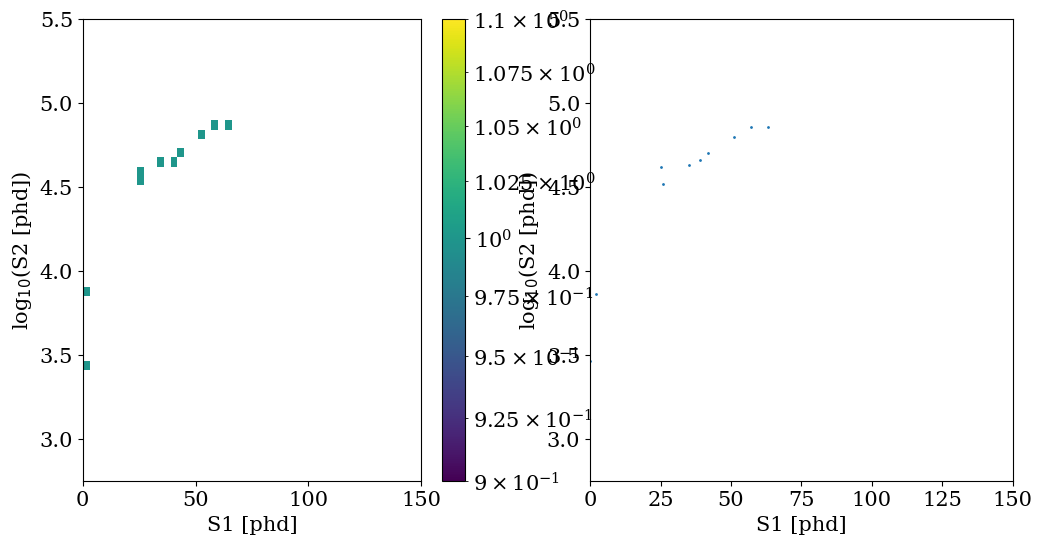

In [62]:
# Components: mostly NEST. Also LZ g1/g2 and double photoelectron emission
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,6))
h2 = ax1.hist2d(detections[:,0], np.log10(detections[:,1]), bins = 50,
           range = [[0, 150],[2.75, 5.5]],norm=LogNorm())
fig.colorbar(h2[3])

ax2.scatter(detections[:,0], np.log10(detections[:,1]), s=1)
ax2.set_xlim(0, 150)
ax2.set_ylim(2.75, 5.5)


ax1.set_xlabel("S1 [phd]")
ax1.set_ylabel("log$_{10}$(S2 [phd])")

ax2.set_xlabel("S1 [phd]")
ax2.set_ylabel("log$_{10}$(S2 [phd])")

# plt.colorbar()

# Validating imports
Imports from AC McDonald 2019 (NEXT)

Interpolation is probably not the best, but it's quick and should be good enough for this script.

$\sigma_D^{(D_LP)} \mathrm{ [ns]}= \sqrt{\left(2\times  10^3\right) \frac{(D_LP)z}{P v_d^3}} \sqrt{\frac{T}{T_0}}$, temperature term added by me, gives better agreement btw results from same source

vs.

$\sigma_D^{(D_L^*)} \mathrm{ [ns]}= \sqrt{\frac{(D_L^*)^2z}{P v_d^2} \frac{T}{T_0}}$

Why is $D_L^*$ at high reduced field strength omitted? They have a point at E~270 V/cm, 1 bar. I guess they didn't think it was important - in the paper, "region of most interest to TPC experiments such as NEXT" extends to 60 V/cm/bar.

In [ ]:
# Drift velocity
fig, ax = plt.subplots()

redFldVDrift = np.linspace(5, 295, 1000)
ax.scatter(vDriftFile[:,0],vDriftFile[:,1], label = "AC McDonald")
ax.plot(redFldVDrift, getVDrift(redFldVDrift), label = "Interpolation")

ax.axvspan(FIELD_STRENGTH/3., FIELD_STRENGTH/1., alpha=0.2, label = "Reduced field strengths\n 260 V/cm, 1-3 bara")
ax.set_xlabel("Reduced Drift Field [V cm$^{-1}$ bar$^{-1}$]")
ax.set_ylabel("Drift Velocity [mm $\mu$s$^{-1}$]")
plt.legend()


# Diffusion coefficient (D_L P)
reducedFieldDLP = np.linspace(6, 270, 1000)
reducedFieldDLstar = np.linspace(6, 63, 1000)

fig, ax = plt.subplots()

ax.scatter(DLPFile[:,0],DLPFile[:,1], label = "AC McDonald")
ax.plot(reducedFieldDLP, getDLP(reducedFieldDLP), label = "Interpolation")

ax.axvspan(FIELD_STRENGTH/3., FIELD_STRENGTH/1., alpha=0.2, label = "Reduced field strengths\n 260 V/cm, 1-3 bara")
ax.set_xlabel("Reduced Drift Field [V cm$^{-1}$ bar$^{-1}$]")
ax.set_ylabel("$D_LP$ [bar cm$^2$ s$^{-1}$]")
plt.legend()


# Diffusion coefficient (D_L^*)
fig, ax = plt.subplots()

ax.scatter(DLstarFile[:,0],DLstarFile[:,1], label = "AC McDonald")
ax.plot(reducedFieldDLstar, getDLstar(reducedFieldDLstar), label = "Interpolation")

ax.axvspan(FIELD_STRENGTH / 3., FIELD_STRENGTH / 1., alpha=0.2, label = "Reduced field strengths\n 260 V/cm, 1-3 bara")
ax.set_xlabel("Reduced Drift Field [V cm$^{-1}$ bar$^{-1}$]")
ax.set_ylabel("$D_L^*$ [$\sqrt{bar}$ $\mu$m $\sqrt{cm}^{-1}$]")
plt.legend()


# Comparing diffusion coefficients
fig, (ax1,ax2) = plt.subplots(2,1)

thisZ = 1 # cm ; plot time diffusion for this vertex depth
sigmaD_DLP = np.sqrt(1e3*2*getDLP(reducedFieldDLP) * thisZ / (PRESSURE * getVDrift(reducedFieldDLP)**3) * TEMP/TEMP_0)
sigmaD_DLstar = np.sqrt(getDLstar(reducedFieldDLstar)**2 * thisZ / (PRESSURE * getVDrift(reducedFieldDLstar)**2) * TEMP / TEMP_0)
ax1.plot(redFldVDrift, sigmaD_DLP,
        label = "$D_LP$")
ax1.plot(reducedFieldDLstar, sigmaD_DLstar,
        label = "$D_L^*$")
ax1.axvspan(FIELD_STRENGTH / 3., FIELD_STRENGTH / 1., alpha=0.2, label = "Reduced field strengths\n 260 V/cm, 1-3 bara")

ax1.set_xlabel("Reduced Drift Field [V cm$^{-1}$ bar$^{-1}$]")
ax1.set_ylabel("$\sigma_D$ [ns]")
ax1.legend()


ax2.plot(redFldVDrift, sigmaD_DLP,
        label = "$D_LP$")
ax2.plot(reducedFieldDLstar, sigmaD_DLstar,
        label = "$D_L^*$")
ax2.axvspan(FIELD_STRENGTH / 3., FIELD_STRENGTH / 1., alpha=0.2, label = "Reduced field strengths\n 260 V/cm, 1-3 bara")
ax2.set_ylim(0.,  2.5e3 / PRESSURE * np.sqrt(z))
ax2.set_xlabel("Reduced Drift Field [V cm$^{-1}$ bar$^{-1}$]")
ax2.set_ylabel("$\sigma_D$ [ns]")


# % difference between diffusion coefficients
fig, ax = plt.subplots()
ax.plot(reducedFieldDLstar, 100*(np.sqrt(1e3*2*getDLP(reducedFieldDLstar) * thisZ / (PRESSURE * getVDrift(reducedFieldDLstar)**3) * TEMP/TEMP_0)
                             - sigmaD_DLstar) / sigmaD_DLstar)

ax.axvspan(FIELD_STRENGTH / 3., FIELD_STRENGTH / 1., alpha=0.2, label = "Reduced field strengths\n 260 V/cm, 1-3 bara")

ax.set_xlabel("Reduced Drift Field [V cm$^{-1}$ bar$^{-1}$]")
ax.set_ylabel("$\\frac{\sigma_D(D_LP) - \sigma_D(D_L^*)}{\sigma_D(D_L^*)}$ (%)")
ax.set_xlim(0,100)

plt.legend()

In [ ]:
y = nc.GetYields(interaction,
		 energy)

print('The photon yield is:', y.PhotonYield)
print('With statistical fluctuations',
      nc.GetQuanta(y).photons)


# Validating functions

Let's make sure the PDF (effectively the observed scintillation wf) and CDF (used to sample scintillation time, and to generate S2 shape) have the expected properties.

I commented out some of the plots so this section wouldn't take up so much space. Simply uncomment and run the cell to view.

The functional form of a single exp convoluted w/ a Gaussian is well known (https://en.wikipedia.org/wiki/Exponentially_modified_Gaussian_distribution)
We have a double exp convoluted w/ a Gaussian. Simply a sum of two of the above with an appropriate normalization.

In [ ]:
# def distScint(t,faFr, tF, tS, sigma):
#     return 1/2 * 1/(faFr*tF + (1-faFr)*tS) * (\
#             faFr*np.exp(-t/tF+sigma**2/(2*tF**2))*erfc((sigma**2/tF - t)/(np.sqrt(2)*sigma)) + \
#             (1-faFr)*np.exp(-t/tS+sigma**2/(2*tS**2))*erfc((sigma**2/tS - t)/(np.sqrt(2)*sigma))  )

t = np.linspace(-500, 1000, 1000)
scintillation = distScint(t, 0.5, 10, 100, 20)
plt.plot(t,scintillation)
print('Integral is %s' % np.trapz(scintillation, t)) # This is ~1. It is in fact a PDF.

The CDF was found by integrating the above in Mathematica from $-\infty$ to $t$. No shockers there. There was an issue - this function runs into float overflows when $\sigma >> \tau$. There's a guard in there to catch this scenario and set the exponential to a large, but finite, number. It should be fine for our purposes.

In [ ]:
# def cdfScint(t,faFr, tF, tS, sigma):

t = np.linspace(-500, 1500, 1000)
cdf = cdfScint(t, 0.5, 10, 100, 40)
plt.plot(t,cdf)
print('Starts at %s' % cdf[0]) # This is ~0. That's a good sign...
print('Ends at %s' % cdf[-1]) # This is ~1. From the plot, it's monotonically increasing. It is in fact a CDF.

# The below plot shows we get the right PDF back when we take the derivative of the CDF
# plt.plot((0.5*np.gradient(cdf) - scintillation) / scintillation) 

The S2 shape is double exp $\ast$ gaussian $\ast$ top hat. Again, the assumptions that go into this are way up there, above the definition. The convolution is trivial once we recognize the Heaviside $\ast$ our PDF is our CDF. The top hat is just two Heavisides, i.e., the wf shape is the difference of two CDF-like shapes.

In [ ]:
# def getS2(t,faFr, tF, tS, sigma, T):
#     return 1/T * (cdfScint(t,faFr,tF,tS,sigma) - cdfScint(t-T,faFr,tF,tS,sigma))

t = np.linspace(-2000, 5000, 1000)
wf = getS2(t, 0.5, 10, 100, 300, 2000)
plt.plot(t,wf) # Does this look like an S2? You decide.

print('Integral is %s' % np.trapz(wf, t)) # This is ~1. It is indeed properly normalized.

# # A few edge cases for this analytical S2 shape
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.plot(t,getS2(t, 0.5, 10, 100,  20, 2000))  # Dominated by top-hat (low diffusion, close to grid)
ax2.plot(t,getS2(t, 0.5, 10, 100, 600, 2000))  # Dominated by gaussian (high diffusion, far from grid)
ax3.plot(t,getS2(t, 0.5, 10, 100,  20,    1))  # Dominated by scintillation (low diffusion and extraction time)

gaussianPhd and applyRMS are pretty self-explanatory. The gaussian is normalized (I checked). I'll leave it at that.

## References

GXe diffusion refs:

A. Simón et al. "Electron drift properties in high pressure gaseous xenon,"  JINST 13 (2018) P07013

A.D. McDonald et al. "Electron drift and longitudinal diffusion in high pressure xenon-helium gas mixtures" JINST 14 (2019) P08009

Note: A.D. McDonald et al. validated pressure independence of v_drift and D_L* as f(reduced field E/P) from P=1-9 bar. Questionable whether valid at low temp.

<table><tr>
<td> <img src="img/vDrift.png" width="300" height="240"> </td>
<td> <img src="img/DLP.png" width="600" height="240"> </td>
</tr></table>
<img src="img/DL*.png" width="300" height="240">

In [50]:
channels = np.random.choice(np.arange(0, N_CHANNELS), 40,
                            p = np.random.dirichlet(0.1 * np.ones(N_CHANNELS), 1)[0])
print(channels)


[11 26 11 19 11 19 19 11 11 11 11 19 19 15 19 11 13 31 13  0 11  1 11 19
 11 19 11 19 11 19 11 11 13 31 19 31 11 11 29 13]


ValueError: operands could not be broadcast together with shapes (1000,) (2,) 